In [12]:
using Distributed
# Script for investigating amplitude dependence of potential
@everywhere using Distributions
@everywhere using Test
@everywhere using StatsBase
@everywhere using BenchmarkTools
@everywhere using LinearAlgebra
@everywhere using LaTeXStrings
using Dates
using Primes
using MCMCDiagnostics
using SharedArrays
using DelimitedFiles
@everywhere src_path = "../Source/"
@everywhere include(src_path*"types.jl")
@everywhere include(src_path*"functions_msc.jl")
@everywhere include(src_path*"functions_neighbors.jl")
@everywhere include(src_path*"functions_types.jl")
@everywhere include(src_path*"functions_energy.jl")
@everywhere include(src_path*"functions_mc.jl")
@everywhere include(src_path*"functions_thermalization.jl")
@everywhere include(src_path*"functions_observables.jl")
@everywhere include(src_path*"functions_symmetries.jl")
@everywhere include(src_path*"jackknife_estimates.jl")
@everywhere include(src_path*"dist_lists.jl")
@everywhere include(src_path*"parallel_tempering.jl")
include(src_path*"functions_plots_and_files.jl")
using Plots
pyplot()

Plots.PyPlotBackend()

# Importing Bojesen version

In [1]:
src_path = "../Source/"
include(src_path*"jackknife_estimates.jl")
include(src_path*"functions_msc.jl")
home = pwd()
cd("../../../FS/FerrenbergSwendsenReweighting.jl/src/")
include("FerrenbergSwendsenReweighting.jl")
cd(home)
using Main.FerrenbergSwendsenReweighting

In [2]:
cd(home)

# Loading results from text files

In [3]:
using DelimitedFiles
using BenchmarkTools
new_energies = readdlm("energies", ':', Float64)
new_results = readdlm("results", ':', Float64)
new_b_list = readdlm("b_list", ':', Float64);

In [4]:
N₀ = size(new_results, 2)
ρˣ₂_by_T = Array{Array{Float64, 1}, 1}(undef, N₀)
E_by_T = Array{Array{Float64, 1}, 1}(undef, N₀)
for k = 1:N₀
    ρˣ₂_by_T[k] = new_results[:, k]
    E_by_T[k] = new_energies[:, k]
end
β_list = reshape(new_b_list, length(new_b_list))

16-element Array{Float64,1}:
 0.5882352941176471
 0.5818964044262726
 0.575625823323181 
 0.5694228147073422
 0.563286650410033 
 0.5572166101093589
 0.5512119812456945
 0.5452720589380379
 0.5393961459012631
 0.5335835523642679
 0.5278335959890009
 0.522145601790362 
 0.5165189020569667
 0.5109528362727634
 0.5054467510394958
 0.5000000000000007

In [5]:
λs = β_list
xs = E_by_T
N₀ = length(λs)
Nₖ = length.(xs)
logprob(β, E) = -β*E;
logprobλx = [[[logprob(λₘ, xs[k][i]) for i = 1:Nₖ[k]] for k = 1:N₀] for λₘ in λs]
essfs = [essf_estimate([boltzmann(λs[i],x) for x ∈ xs[i]]) for i=1:N₀]
ln_gₖ = log.(essfs)
eff_lengths = Nₖ .* essfs #Effective Sample SizeS
ln_eff_lengths = log.(eff_lengths)
ΔlogZs = [logprobλx[m][1][1] - logprobλx[1][1][1] for m = 2:N₀] #Approximate initialization of logZ difference
typeof(logprobλx)

UndefVarError: UndefVarError: boltzmann not defined

In [6]:
@benchmark ΔlnZ($ΔlogZs, $logprobλx, $ln_gₖ, $ln_eff_lengths, $Nₖ, $N₀)

BenchmarkTools.Trial: 
  memory estimate:  21.53 MiB
  allocs estimate:  131872
  --------------
  minimum time:     298.709 ms (0.54% GC)
  median time:      312.232 ms (0.52% GC)
  mean time:        311.129 ms (2.85% GC)
  maximum time:     324.752 ms (28.10% GC)
  --------------
  samples:          17
  evals/sample:     1

In [6]:
rw = ReweightObj(β_list, E_by_T; logarithms=true);

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.475068e-01              NaN
     1     2.954362e-02     3.829344e+00
     2     5.461706e-03     6.905822e+00
     3     2.648387e-03     3.816832e+00
     4     9.416564e-07     2.468566e-02
     5     1.421085e-12     9.281166e-05
Calculated ΔlogZs:
[8.35376, 20.6576, 37.224, 58.7593, 85.1627, 116.909, 153.376, 194.353, 242.193, 297.543, 357.077, 421.216, 488.979, 560.065, 633.725]
In 0.2741643189 m


In [10]:
weights = evaluate(rw, (β_list[1]+β_list[2])/2)
sum(sum.(weights))

65536.00000000003

In [11]:
maximum(maximum.(weights))

14.93848124663774

In [12]:
FSexpression(logprobλx, ΔlogZs, essfs, eff_lengths, Nₖ, N₀).-1

15-element Array{Float64,1}:
 -0.89616348096321  
 -0.958718500937023 
 -0.9803401206548573
 -0.9760981950862552
 -0.9936544209578999
 -0.9917166652968842
 -0.9947728189195224
 -0.9958514337538874
 -0.9989118731051956
 -0.9971692841213892
 -0.993249424089842 
 -0.9638840952945257
 -0.9487231864255641
 -0.8214713504432096
 13.62967490516191  

In [10]:
@benchmark FSexpression($logprobλx, $ΔlogZs, $essfs, $eff_lengths, $Nₖ, $N₀)

BenchmarkTools.Trial: 
  memory estimate:  223.75 MiB
  allocs estimate:  13549649
  --------------
  minimum time:     858.536 ms (4.45% GC)
  median time:      910.896 ms (4.36% GC)
  mean time:        904.883 ms (4.43% GC)
  maximum time:     925.444 ms (4.73% GC)
  --------------
  samples:          6
  evals/sample:     1

# Using calculated weights

In [6]:
L = 24

24

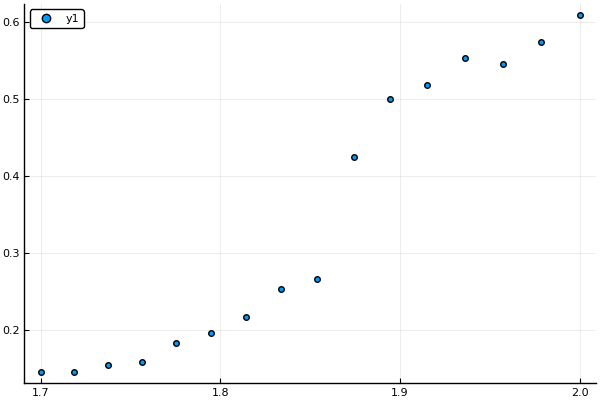

In [7]:
scatter([1/β for β in β_list], L.*mean.(ρˣ₂_by_T))

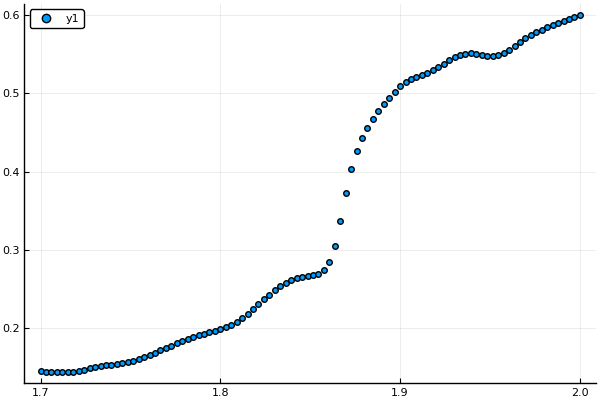

In [11]:
N_temps = 100
# Make a inverse temperature range consisting of N_temps temperatures.
sorted_β_list = sort(β_list)
new_T_list = 1/sorted_β_list[end]:(1/sorted_β_list[1] - 1/sorted_β_list[end])/(N_temps-1):1/sorted_β_list[1]
o_type = typeof(ρˣ₂_by_T[1][1])
#N_temps = length(new_T_list)
O_by_T = fill(o_type(0), N_temps)
for j = 1:N_temps
    # Calculate weights
    weights = evaluate(rw, 1/new_T_list[j])
    # We calculate the sum of ρ′ᵢ = ρᵢwᵢ
    N₀ = length(weights)
    for k = 1:N₀
        O_by_T[j] += sum(ρˣ₂_by_T[k] .* weights[k])
    end
    O_by_T[j] /= sum(sum.(weights))
end
scatter(new_T_list, L.*O_by_T)

# Calculating reweighted points with jackknife error
To get the Jackknife variables we need to construct an estimator function that takes as input the energies and the $\rho^x_2$ observables and spits out an estimate for $\rho^x_2$ for all reweighted points.

In [14]:
function reweightWithError(O_by_T::Vector{Vector{T}}, E_by_T::Vector{Vector{R}}, orig_βs::Vector{R},
        rwt_βs::Vector{R}; num_blocks=2^7, skip_check=false) where {T, R<:Real}
    
    (N₀ = length(orig_βs)) == length(O_by_T) == length(E_by_T) || throw(error("ERROR: Length of input vectors did not agree.
Are you sure that we have corresponding observables, energies and inverse temperatures?"))
    length.(O_by_T) == length.(E_by_T) || throw(error("ERROR: Length of time series of observables 
and energies did not agree"))
    
    N_temps = length(rwt_βs)
    rwt_Os = Array{T, 1}(undef, N_temps)
    rwt_errs = Array{T, 1}(undef, N_temps)
    
    # Create reweight object based on full set of measurements for the purpose of an initial guess of ΔlogZs
    rw = ReweightObj(orig_βs, E_by_T; logarithms=true, verbose=true);
    initial_guess = rw.ΔlogZs
    
    # Estimator function takes in observable array and corresponding energies,
    # giving reweighted estimates for each β in rwt_βs. Used in a jackknife estimate, this solves the
    # FS equations for a reduced set of energies for each jackknife variable.
    # Assumes that orig_βs, rwt_βs and initial_guess are defined in outer scope.
    function θ_estimator(os::Array{Array{T, 1}, 1}, es::Array{Array{R, 1}, 1}) where {T, R<:Real}
        N₀ = length(os)
        # Create reweight object and solve FS equations
        rw = ReweightObj(orig_βs, es; logarithms=true, initial_guess=initial_guess, verbose=false);
        # Update initial guess.
        initial_guess = rw.ΔlogZs
        # Return vector of reweighted observables.
        reweight(os, rw, rwt_βs)
    end@everywhere src_path = "../Source/"
    
    # Calculate jackknife variables using the θ-estimator giving a num_blcoks length vector of
    # vectors, where each inner vector contains the jackknife variable for each β in rwt_βs.
    j_vars = jackVars(θ_estimator, O_by_T, E_by_T; num_blocks=num_blocks, skip_check=skip_check);
    
    # Now we use the jackknife-variables to estimate the mean and error in the measurements.
    ot = typeof(O_by_T[1][1])
    rwt_Os = Array{ot, 1}(undef, N_temps)
    rwt_errs = Array{ot, 1}(undef, N_temps)
    for i = 1:N_temps
        j_mean, j_var = jackEstimate([j_vars[m][i] for m = 1:num_blocks])
        rwt_Os[i] = j_mean
        rwt_errs[i] = √(j_var)
    end
    
    rwt_Os, rwt_errs
end

reweightWithError (generic function with 1 method)

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.475068e-01              NaN
     1     2.954362e-02     3.829344e+00
     2     5.461706e-03     6.905822e+00
     3     2.648387e-03     3.816832e+00
     4     9.416561e-07     2.468566e-02
     5     1.705303e-12     9.281164e-05
Calculated ΔlogZs:
[8.35376, 20.6576, 37.224, 58.7593, 85.1627, 116.909, 153.376, 194.353, 242.193, 297.543, 357.077, 421.216, 488.979, 560.065, 633.725]
In 0.269270902 m


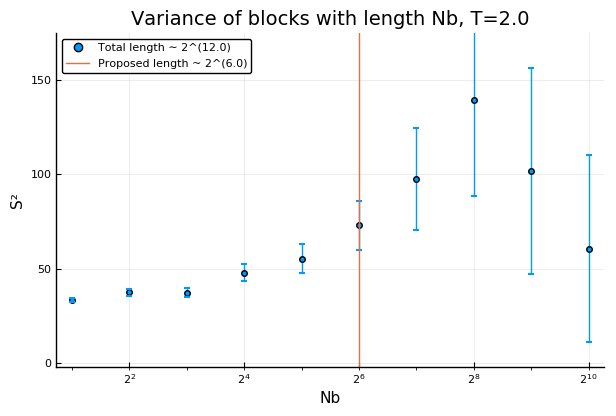

458.456884 seconds (330.04 M allocations: 88.696 GiB, 5.07% gc time)


In [6]:
N_temps = 100
# Make a inverse temperature range consisting of N_temps temperatures.
sorted_β_list = sort(β_list)
rwt_T_list = 1/sorted_β_list[end]:(1/sorted_β_list[1] - 1/sorted_β_list[end])/(N_temps-1):1/sorted_β_list[1]
@time rwt_Os, rwt_errs = reweightWithError(ρˣ₂_by_T, E_by_T, β_list,
    [1/T for T ∈ rwt_T_list]; num_blocks=2^6, skip_check=true);

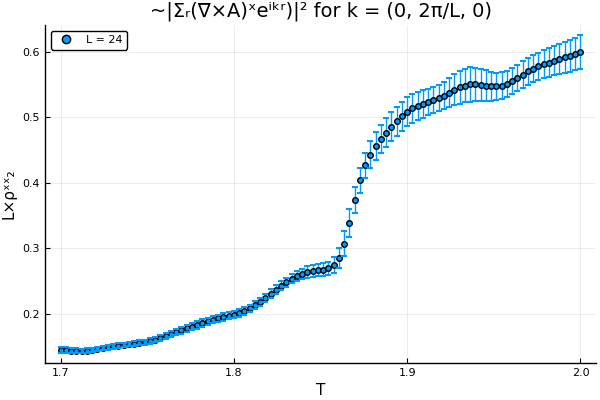

In [7]:
L = 24
plt = scatter(rwt_T_list, L.*rwt_Os; yerror=L.*rwt_errs, xaxis="T", yaxis="L×ρˣˣ₂", label="L = 24", 
    title="~|Σᵣ(∇×A)ˣeⁱᵏʳ)|² for k = (0, 2π/L, 0)")

In [10]:
savefig(plt, "rwt_plot.pdf")

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.475068e-01              NaN
     1     2.954362e-02     3.829344e+00
     2     5.461706e-03     6.905822e+00
     3     2.648387e-03     3.816832e+00
     4     9.416563e-07     2.468566e-02
     5     1.591616e-12     9.281274e-05
Calculated ΔlogZs:
[8.35376, 20.6576, 37.224, 58.7593, 85.1627, 116.909, 153.376, 194.353, 242.193, 297.543, 357.077, 421.216, 488.979, 560.065, 633.725]
In 0.15095295688333332 m


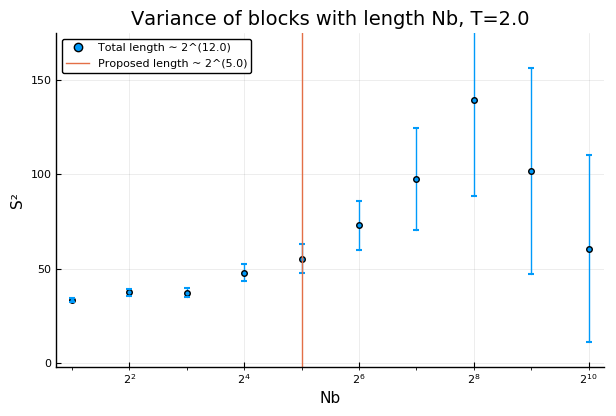

705.094744 seconds (483.54 M allocations: 156.704 GiB, 4.68% gc time)


In [8]:
@time rwt_Os, rwt_errs = reweightWithError(ρˣ₂_by_T, E_by_T, β_list,
    [1/T for T ∈ rwt_T_list]; num_blocks=2^7);

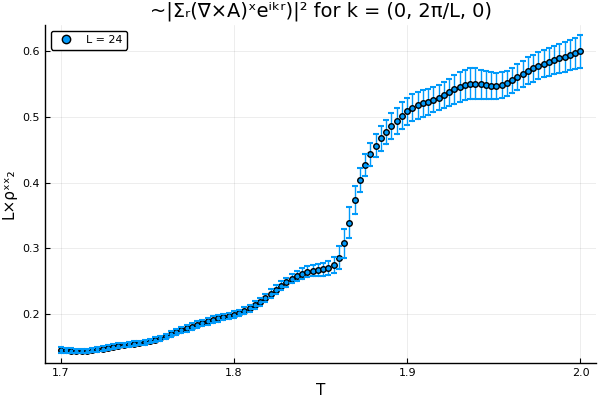

In [9]:
scatter(rwt_T_list, L.*rwt_Os; yerror=L.*rwt_errs, xaxis="T", yaxis="L×ρˣˣ₂", label="L = 24", 
    title="~|Σᵣ(∇×A)ˣeⁱᵏʳ)|² for k = (0, 2π/L, 0)")

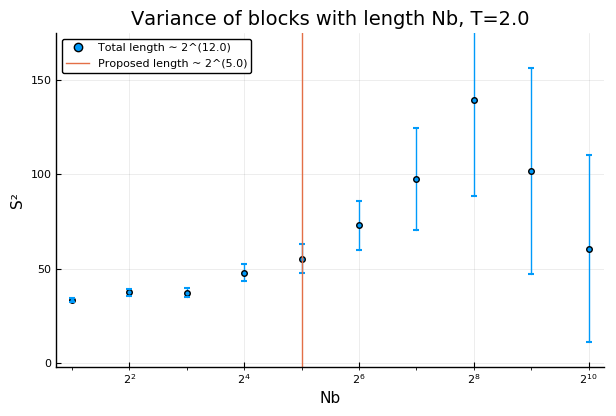

 19.095916 seconds (1.71 M allocations: 79.567 MiB, 0.28% gc time)


In [135]:
@time varianceByBlockLengthPlots(ρˣ₂_by_T, E_by_T, β_list);

In [12]:
T_list = [1/β for β in β_list]
N_T = length(ρˣ₂_by_T)
ρˣ₂_avg_by_T = Array{Float64}(undef, N_T); ρˣ₂_err_by_T = Array{Float64}(undef, N_T);
for i = 1:N_T
    jv = jackVars(mean, ρˣ₂_by_T[i], 2^5; skip_check=true)
    ρˣ₂_avg_by_T[i], var = jackEstimate(jv)
    ρˣ₂_err_by_T[i] = √(var)
end

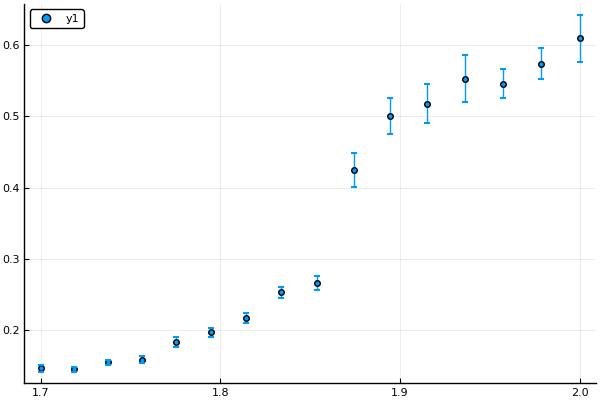

In [14]:
scatter(T_list, L.*ρˣ₂_avg_by_T, yerror=L.*ρˣ₂_err_by_T)

In [15]:
# Computing error
√(sum([err^2 for err in rwt_errs])/length(rwt_errs)) / √(sum([err^2 for err in ρˣ₂_err_by_T])/length(ρˣ₂_err_by_T))

0.805232591239096

In [136]:
rm("var_by_block_length_obs", recursive=true)

# Why is the error not reduced?
Possible solution is the energy-histograms are not overlapping

In [18]:
using StatsBase

In [24]:
N = L^3

13824

In [64]:
# Plots energy histograms for all the energy series contained in E_by_T and saves the plot in energy_histogram.pdf in the
# current folder unless another filename is specified. It uses automatic determination of bins for each energy-series
# unless nbins is specified.
# uses StatsBase, Plots - pyplot
function plotEnergyHistograms(E_by_T::Vector{Vector{T}}, temps::Vector{T}; 
        nbins=-1, filename="energy_histograms.pdf") where {T}
    
    N₀ = length(E_by_T)
    title = "Energy histograms for $(length(temps)) temperatures"
    # If we are using automatic number of bins
    if nbins==-1
        # Make first histogram
        hist = fit(Histogram, E_by_T[1])
        edges = collect(hist.edges[1])
        xs = [(edges[i] + edges[i+1])/2 for i = 1:length(edges)-1]
        ys = hist.weights
        plt = plot(xs, ys; label="T = $(temps[1])", xaxis="Energy pr. site", yaxis="number in bin", title=title);
        for k = 2:N₀
            hist = fit(Histogram, E_by_T[k])
            edges = collect(hist.edges[1])
            xs = [(edges[i] + edges[i+1])/2 for i = 1:length(edges)-1]
            ys = hist.weights
            plot!(plt, xs, ys; label="T = $(temps[k])");
        end
    else
        # If we are using fixed number of bins
        # Make first histogram
        hist = fit(Histogram, E_by_T[1]; nbins=nbins)
        edges = collect(hist.edges[1])
        xs = [(edges[i] + edges[i+1])/2 for i = 1:length(edges)-1]
        ys = hist.weights
        plt = plot(xs, ys; label="T = $(temps[1])", xaxis="Energy pr. site", yaxis="number in bin", title=title)
        for k = 2:N₀
            hist = fit(Histogram, E_by_T[k]; nbins=nbins)
            edges = collect(hist.edges[1])
            xs = [(edges[i] + edges[i+1])/2 for i = 1:length(edges)-1]
            ys = hist.weights
            plot!(plt, xs, ys; label="T = $(temps[k])");
        end
    end
    savefig(plt, filename);
    nothing
end

plotEnergyHistograms (generic function with 1 method)

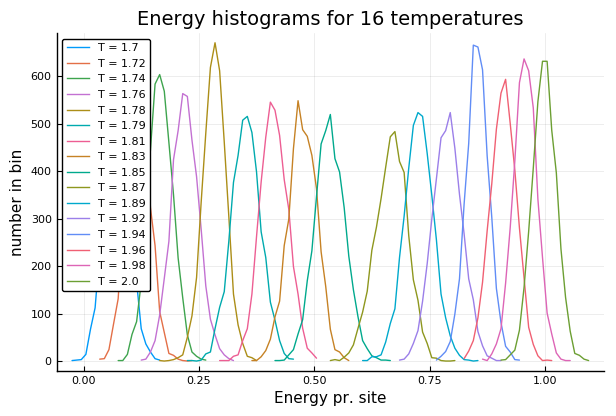

In [65]:
plotEnergyHistograms([Es./N for Es in E_by_T], [round(1/β; digits=2) for β in β_list]; nbins=30)

In [35]:
hist = fit(Histogram, E_by_T[1]./N)
edges = collect(hist.edges[1])
xs = [(edges[k] + edges[k+1])/2 for k = 1:length(edges)-1]

11-element Array{Float64,1}:
 -0.03               
 -0.01               
  0.01               
  0.03               
  0.05               
  0.07               
  0.09               
  0.11               
  0.13               
  0.15000000000000002
  0.16999999999999998

In [32]:
length(hist.weights)

11

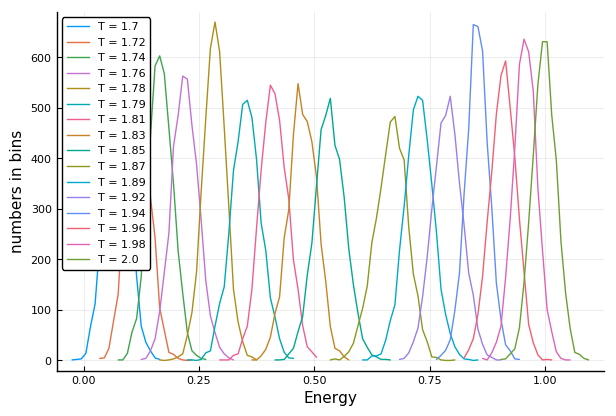

In [57]:
bins = 30
hist = fit(Histogram, E_by_T[1]./N; nbins=bins)
edges = collect(hist.edges[1])
xs = [(edges[k] + edges[k+1])/2 for k = 1:length(edges)-1]
ys = hist.weights
plt = plot(xs, ys; label="T = $(round(1/β_list[1], digits=2))", xaxis="Energy", yaxis="numbers in bins")
for k = 2:N₀
    hist = fit(Histogram, E_by_T[k]./N; nbins=bins)
    edges = collect(hist.edges[1])
    xs = [(edges[i] + edges[i+1])/2 for i = 1:length(edges)-1]
    ys = hist.weights
    plot!(plt, xs, ys; label="T = $(round(1/β_list[k], digits=2))")
end
savefig(plt, "energy_histograms.pdf")